# Modelisation RNN avec GRU

## Librairies et fichiers

In [1]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1_2JJeYhhAHn4xWGD5kC2VtjM-_SxznEm/nov23_bds_rakuten


Import des librairies

In [2]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, GRU, Dense

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification

import matplotlib.pyplot as plt
import seaborn as sns

Chargement du fichier source output/data-preprocessing-resampling/df_train.csv

Fichier contenant le texte nettoyé, mais avec le contexte (le sens)

In [3]:
df_train = pd.read_csv('output/data-preprocessing-resampling/df_train.csv', index_col=0)
display(df_train.head(2))
df_test = pd.read_csv('output/data-preprocessing-resampling/df_test.csv', index_col=0)
display(df_test.head(2))


,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,131641431,885888766,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,fr,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,10/image_885888766_product_131641431.jpg,10
1,745789761,1304710852,The Inglorious Arts Of Peace: Exhibitions In C...,en,Les arts de la paix sans gloire: expositions d...,10/image_1304710852_product_745789761.jpg,10


,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
index,,,,,,,
29927,3469563513,1215209457,Adventure Parks Heavy Duty Tree Strap - Dont t...,en,Les parcs d'aventure STRAP DURT DE DURG - N'at...,1280/image_1215209457_product_3469563513.jpg,1280
42596,4152889175,1309607798,Magideal 2 Pcs Orff Instrument De Musique Hoch...,fr,Magideal 2 Pcs Orff Instrument De Musique Hoch...,1320/image_1309607798_product_4152889175.jpg,1320


## Prétraitement du texte

**Tokenisation et conversion** en séquences numériques

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text_fr'])

X_train = tokenizer.texts_to_sequences(df_train['text_fr'])
X_test = tokenizer.texts_to_sequences(df_test['text_fr'])

vocab_size = len(tokenizer.word_index) + 1  # Ajout de 1 pour le mot réservé 0 (pour le padding)

**Padding des séquences** pour qu'elles aient toutes la même longueur

In [5]:
maxlen = max(len(x) for x in X_train)

X_train = pad_sequences(X_train, padding = 'post', maxlen = maxlen)
X_test = pad_sequences(X_test, padding = 'post', maxlen = maxlen)

Conversion des étiquettes cibles en format catégoriel

In [6]:
num_categories = df_train['prdtypecode'].nunique()

In [7]:
# Vérifier que les codes sont mappés à des indices séquentiels
label_mapping = {code: idx for idx, code in enumerate(df_train['prdtypecode'].unique())}

y_train = to_categorical(df_train['prdtypecode'].map(label_mapping), num_classes=num_categories)
y_test = to_categorical(df_test['prdtypecode'].map(label_mapping), num_classes=num_categories)

In [8]:
# Catégories pour visu matrice
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech.",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant, déguisement",
    1281 : "Jeu de société",
    1300 : "Jouet tech",
    1301 : "Paire de chaussettes",
    1302 : "Jeu extérieur, vêtement",
    1320 : "Autour du bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues et journaux",
    2403 : "Magazines, livres et BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique et papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Autour de la piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

# **Modélisation**

## Construction du modèle RNN avec GRU

Ligne pour charger le modèle préentrainé

In [11]:
model = load_model('output/data-modeling-text-4-RNN-GRU/modele.keras')

Création du modèle

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))  # 100 est la dimension de l'espace de plongement
model.add(GRU(128, return_sequences=True))
model.add(GRU(128))
model.add(Dense(num_categories, activation='softmax'))  # 27 catégories de prdtypecode

Compilation du modèle

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Résumé du modèle

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2059, 100)         16124900  
                                                                 
 gru_2 (GRU)                 (None, 2059, 128)         88320     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                                 
Total params: 16315775 (62.24 MB)
Trainable params: 16315775 (62.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Entraînement

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
3424/3424 [==============================] - 608s 176ms/step - loss: 3.2974 - accuracy: 0.0353 - val_loss: 3.2941 - val_accuracy: 0.1202
Epoch 2/10
3424/3424 [==============================] - 463s 135ms/step - loss: 3.2967 - accuracy: 0.0379 - val_loss: 3.2913 - val_accuracy: 0.0597
Epoch 3/10
3424/3424 [==============================] - 464s 135ms/step - loss: 3.2967 - accuracy: 0.0360 - val_loss: 3.2941 - val_accuracy: 0.0366
Epoch 4/10
3424/3424 [==============================] - 462s 135ms/step - loss: 3.2984 - accuracy: 0.0375 - val_loss: 3.4897 - val_accuracy: 0.0595
Epoch 5/10
3424/3424 [==============================] - 452s 132ms/step - loss: 3.3211 - accuracy: 0.0384 - val_loss: 3.2869 - val_accuracy: 0.0584
Epoch 6/10
3424/3424 [==============================] - 450s 131ms/step - loss: 2.9167 - accuracy: 0.1219 - val_loss: 2.6509 - val_accuracy: 0.1470
Epoch 7/10
3424/3424 [==============================] - 457s 134ms/step - loss: 2.0923 - accuracy: 0.3607 - val_

Enregistrement du Modèle

In [ ]:
model.save('output/data-modeling-text-4-RNN-GRU/modele.keras')  # Enregistre le modèle au format HDF5

## Évaluation

In [12]:
y_pred = model.predict(X_test)

266/266 [==============================] - 17s 61ms/step


In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy: ", accuracy)

266/266 [==============================] - 16s 55ms/step - loss: 1.1582 - accuracy: 0.7023
Test Accuracy:  0.7023080587387085


In [34]:
# Création du dictionnaire inverse des labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Convertir les catégories one-hot en étiquettes numériques
y_test_labels = np.argmax(y_test, axis = 1)
# Mapper les étiquettes numériques à leurs labels prdtypecode
y_test_original = [inverse_label_mapping.get(index) for index in y_test_labels]
# Mapper les labels à leurs Catégories pour visu prdcodetype2label
y_test_visu = [prdcodetype2label.get(code, "Label") for code in y_test_original]

# y_pred
y_pred_labels = np.argmax(y_pred, axis = 1)
y_pred_original = [inverse_label_mapping.get(index) for index in y_pred_labels]
y_pred_visu = [prdcodetype2label.get(code, "Label") for code in y_pred_original]

Score du modèle : 0.7023080546396608


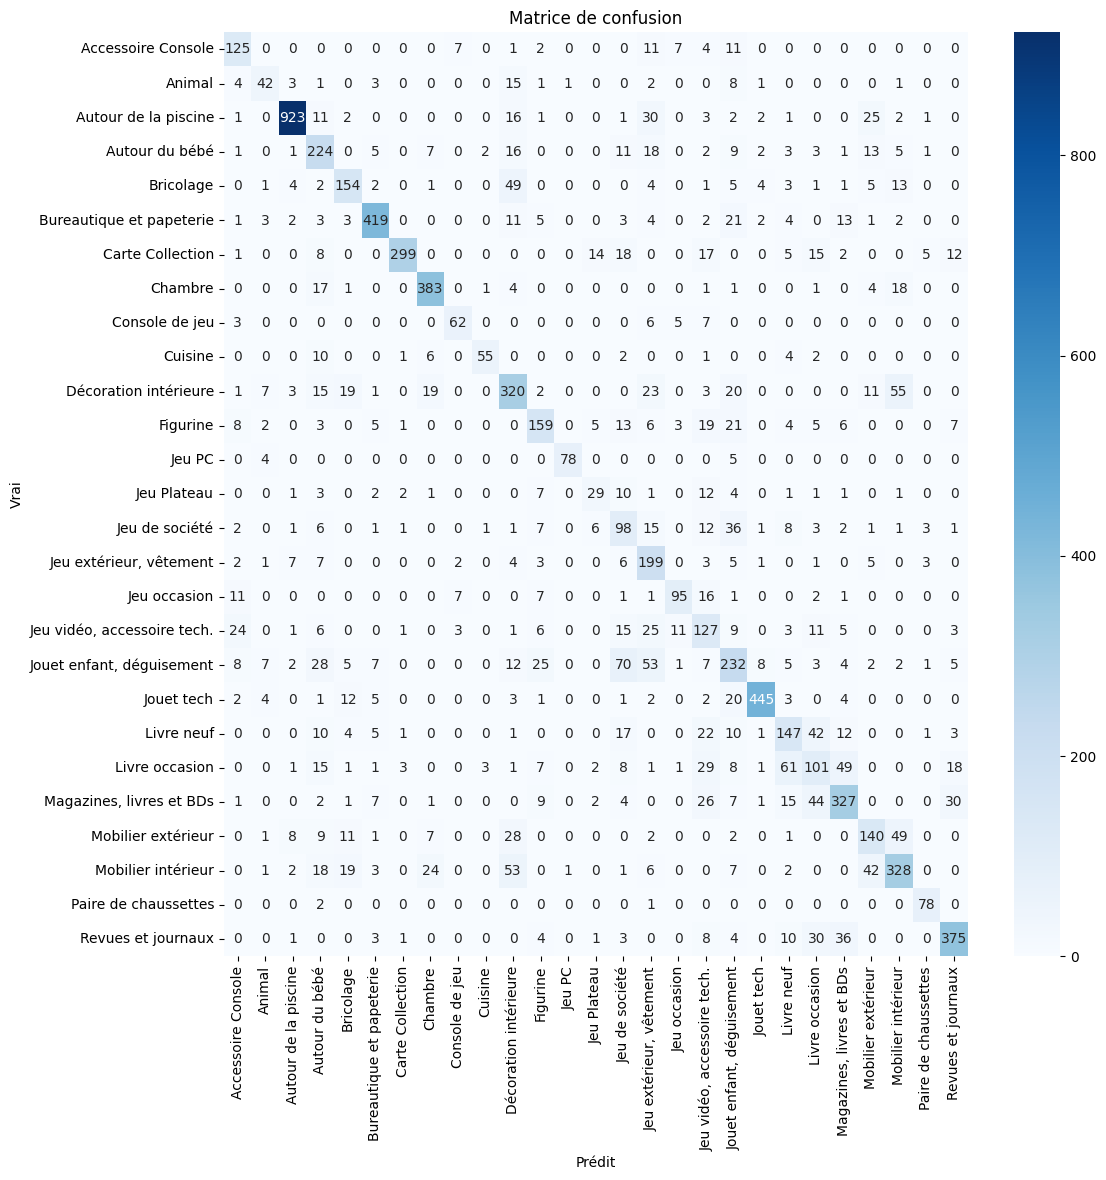

In [35]:
# Calculer le score du modèle
score = accuracy_score(y_test_visu, y_pred_visu)
print("Score du modèle :", score)

# Créer et afficher la matrice de confusion
mat_conf = pd.crosstab(y_test_visu, y_pred_visu)

plt.figure(figsize=(12, 12))
sns.heatmap(mat_conf, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()

In [36]:
print(classification_report(y_test_visu, y_pred_visu))

                             precision    recall  f1-score   support

         Accessoire Console       0.64      0.74      0.69       168
                     Animal       0.58      0.51      0.54        82
       Autour de la piscine       0.96      0.90      0.93      1021
             Autour du bébé       0.56      0.69      0.62       324
                  Bricolage       0.66      0.62      0.64       250
   Bureautique et papeterie       0.89      0.84      0.86       499
           Carte Collection       0.96      0.76      0.85       396
                    Chambre       0.85      0.89      0.87       431
             Console de jeu       0.77      0.75      0.76        83
                    Cuisine       0.89      0.68      0.77        81
      Décoration intérieure       0.60      0.64      0.62       499
                   Figurine       0.65      0.60      0.62       267
                     Jeu PC       0.97      0.90      0.93        87
                Jeu Plateau      